In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/Cinema_Audience_Forecasting_challenge/movie_theater_id_relation/movie_theater_id_relation.csv
/kaggle/input/Cinema_Audience_Forecasting_challenge/date_info/date_info.csv
/kaggle/input/Cinema_Audience_Forecasting_challenge/sample_submission/sample_submission.csv
/kaggle/input/Cinema_Audience_Forecasting_challenge/booknow_theaters/booknow_theaters.csv
/kaggle/input/Cinema_Audience_Forecasting_challenge/cinePOS_booking/cinePOS_booking.csv
/kaggle/input/Cinema_Audience_Forecasting_challenge/cinePOS_theaters/cinePOS_theaters.csv
/kaggle/input/Cinema_Audience_Forecasting_challenge/booknow_visits/booknow_visits.csv
/kaggle/input/Cinema_Audience_Forecasting_challenge/booknow_booking/booknow_booking.csv


**ACTUAL EXECUTION**

**1. IMPORT, CHECKING, LOADING AND EDA**

In [2]:
# 0. Import Data

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

import warnings
warnings.filterwarnings("ignore")

pd.set_option("display.max_columns", 200)
sns.set(style="whitegrid", font_scale=1.0)

RANDOM_STATE = 42


# 1. Load data 

DATA_PATH = "."

cpt       = pd.read_csv("/kaggle/input/Cinema_Audience_Forecasting_challenge/cinePOS_theaters/cinePOS_theaters.csv")
bnt       = pd.read_csv("/kaggle/input/Cinema_Audience_Forecasting_challenge/booknow_theaters/booknow_theaters.csv")
rel       = pd.read_csv("/kaggle/input/Cinema_Audience_Forecasting_challenge/movie_theater_id_relation/movie_theater_id_relation.csv")
cpb       = pd.read_csv("/kaggle/input/Cinema_Audience_Forecasting_challenge/cinePOS_booking/cinePOS_booking.csv")
bnb       = pd.read_csv("/kaggle/input/Cinema_Audience_Forecasting_challenge/booknow_booking/booknow_booking.csv")
data      = pd.read_csv("/kaggle/input/Cinema_Audience_Forecasting_challenge/booknow_visits/booknow_visits.csv")
date_info = pd.read_csv("/kaggle/input/Cinema_Audience_Forecasting_challenge/date_info/date_info.csv")
ss        = pd.read_csv("/kaggle/input/Cinema_Audience_Forecasting_challenge/sample_submission/sample_submission.csv")

print("cpt:", cpt.shape)
print("bnt:", bnt.shape)
print("rel:", rel.shape)
print("cpb:", cpb.shape)
print("bnb:", bnb.shape)
print("data:", data.shape)
print("date_info:", date_info.shape)
print("ss:", ss.shape)

# Ensure date types
data["show_date"] = pd.to_datetime(data["show_date"])
date_info["show_date"] = pd.to_datetime(date_info["show_date"])

cpt: (4690, 5)
bnt: (829, 5)
rel: (150, 2)
cpb: (1641966, 4)
bnb: (68336, 4)
data: (214046, 3)
date_info: (547, 2)
ss: (38062, 2)


In [3]:
bnb.shape

(68336, 4)

In [4]:
cpt = pd.read_csv("/kaggle/input/Cinema_Audience_Forecasting_challenge/cinePOS_theaters/cinePOS_theaters.csv")

In [5]:
cpt.dtypes

cine_theater_id     object
theater_type        object
theater_area        object
latitude           float64
longitude          float64
dtype: object

In [6]:
bnt = pd.read_csv("/kaggle/input/Cinema_Audience_Forecasting_challenge/booknow_theaters/booknow_theaters.csv")

In [7]:
bnt["theater_type"].value_counts()

theater_type
Other     411
Comedy    196
Drama     183
Action     39
Name: count, dtype: int64

In [8]:
cpb = pd.read_csv("/kaggle/input/Cinema_Audience_Forecasting_challenge/cinePOS_booking/cinePOS_booking.csv")

In [9]:
cpb.head()

cine_theater_id        show_datetime     booking_datetime  tickets_sold
0   cinePOS_00001  2023-01-01 11:00:00  2023-01-01 09:00:00             1
1   cinePOS_00002  2023-01-01 13:00:00  2023-01-01 06:00:00             3
2   cinePOS_00003  2023-01-01 16:00:00  2023-01-01 14:00:00             2
3   cinePOS_00004  2023-01-01 17:00:00  2023-01-01 11:00:00             5
4   cinePOS_00005  2023-01-01 17:00:00  2023-01-01 03:00:00            13

In [10]:
cpb.nunique()

cine_theater_id     13161
show_datetime        8283
booking_datetime    10152
tickets_sold           97
dtype: int64

In [11]:
rel = pd.read_csv('/kaggle/input/Cinema_Audience_Forecasting_challenge/movie_theater_id_relation/movie_theater_id_relation.csv')

In [12]:
rel.head()

book_theater_id cine_theater_id
0      book_00509   cinePOS_01261
1      book_00063   cinePOS_02467
2      book_00054   cinePOS_08923
3      book_00094   cinePOS_02479
4      book_00052   cinePOS_06750

In [13]:
date_info = pd.read_csv("/kaggle/input/Cinema_Audience_Forecasting_challenge/date_info/date_info.csv")

In [14]:
date_info.head()

show_date day_of_week
0  2023-01-01      Sunday
1  2023-01-02      Monday
2  2023-01-03     Tuesday
3  2023-01-04   Wednesday
4  2023-01-05    Thursday

In [15]:
data = pd.read_csv("/kaggle/input/Cinema_Audience_Forecasting_challenge/booknow_visits/booknow_visits.csv")

In [16]:
data.head()

book_theater_id   show_date  audience_count
0      book_00001  2023-01-13              50
1      book_00001  2023-01-14              64
2      book_00001  2023-01-15              58
3      book_00001  2023-01-16              44
4      book_00001  2023-01-18              12

In [17]:
data.tail()

book_theater_id   show_date  audience_count
214041      book_00829  2024-02-23              16
214042      book_00829  2024-02-24               8
214043      book_00829  2024-02-25              16
214044      book_00829  2024-02-27              16
214045      book_00829  2024-02-28              16

In [18]:
ss = pd.read_csv("/kaggle/input/Cinema_Audience_Forecasting_challenge/sample_submission/sample_submission.csv")

In [19]:
ss.tail()

ID  audience_count
38057  book_00829_2024-04-18               0
38058  book_00829_2024-04-19               0
38059  book_00829_2024-04-20               0
38060  book_00829_2024-04-21               0
38061  book_00829_2024-04-22               0

In [20]:
ss.head()

ID  audience_count
0  book_00001_2024-03-01               0
1  book_00001_2024-03-02               0
2  book_00001_2024-03-03               0
3  book_00001_2024-03-04               0
4  book_00001_2024-03-06               0


Date range: 2023-01-01 00:00:00 -> 2024-02-28 00:00:00

Describe audience_count:
count    214046.000000
mean         41.616568
std          32.834918
min           2.000000
25%          18.000000
50%          34.000000
75%          58.000000
max        1350.000000
Name: audience_count, dtype: float64


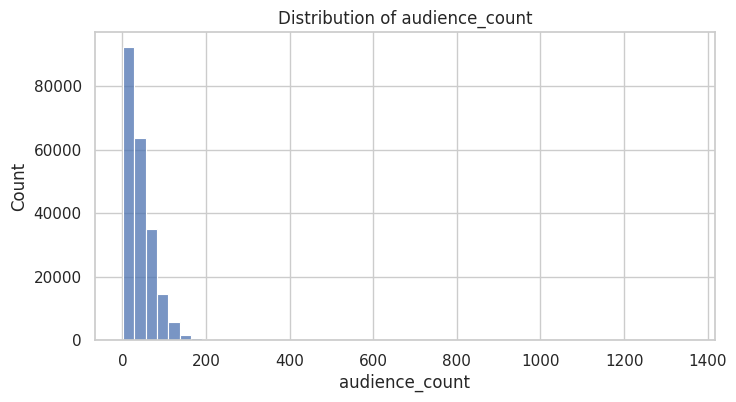

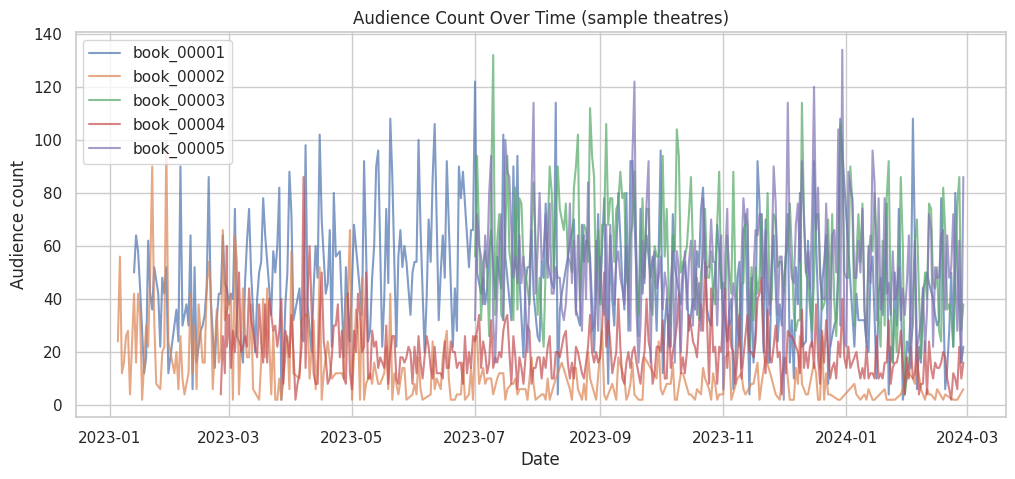

In [21]:
#  GRAPHS 

data["show_date"] = pd.to_datetime(data["show_date"])
date_info["show_date"] = pd.to_datetime(date_info["show_date"])

print("\nDate range:",
      data["show_date"].min(), "->", data["show_date"].max())

print("\nDescribe audience_count:")
print(data["audience_count"].describe())

# Distribution of target
plt.figure(figsize=(8, 4))
sns.histplot(data["audience_count"], bins=50)
plt.title("Distribution of audience_count")
plt.show()

# Audience over time for a few theatres
sample_theaters = data["book_theater_id"].unique()[:5]
plt.figure(figsize=(12, 5))
for tid in sample_theaters:
    tmp = data[data["book_theater_id"] == tid].sort_values("show_date")
    plt.plot(tmp["show_date"], tmp["audience_count"], label=tid, alpha=0.7)
plt.title("Audience Count Over Time (sample theatres)")
plt.xlabel("Date")
plt.ylabel("Audience count")
plt.legend()
plt.show()


In [22]:
# INSPECTION
datasets = {
    "CinePOS Theaters": cpt,
    "BookNow Theaters": bnt,
    "ID Relation": rel,
    "CinePOS Booking": cpb,
    "BookNow Booking": bnb,
    "Daily Audience": data,
    "Calendar Info": date_info,
}

for name, df in datasets.items():
    print("\n\n===============================")
    print(f"📌 DATASET: {name}")
    print("===============================")
    print(df.head())
    print(df.info())
    print(df.describe(include="all"))



📌 DATASET: CinePOS Theaters
  cine_theater_id theater_type theater_area   latitude  longitude
0   cinePOS_05466        Other     Area_104  22.619233  78.113017
1   cinePOS_08708        Other     Area_104  22.619233  78.113017
2   cinePOS_00753        Other     Area_104  22.619233  78.113017
3   cinePOS_05776        Other     Area_104  22.619233  78.113017
4   cinePOS_07536        Other     Area_104  23.004410  79.934515
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4690 entries, 0 to 4689
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   cine_theater_id  4690 non-null   object 
 1   theater_type     4690 non-null   object 
 2   theater_area     4690 non-null   object 
 3   latitude         829 non-null    float64
 4   longitude        829 non-null    float64
dtypes: float64(2), object(3)
memory usage: 183.3+ KB
None
       cine_theater_id theater_type theater_area    latitude   longitude
count         

In [23]:

# CHECKING MISSING VALUES

for name, df in datasets.items():
    print("\n\n======== Missing Values:", name, "========")
    print(df.isna().sum().sort_values(ascending=False))



======== Missing Values: CinePOS Theaters ========
latitude           3861
longitude          3861
cine_theater_id       0
theater_type          0
theater_area          0
dtype: int64


======== Missing Values: BookNow Theaters ========
book_theater_id    515
theater_type         0
theater_area         0
latitude             0
longitude            0
dtype: int64


======== Missing Values: ID Relation ========
book_theater_id    0
cine_theater_id    0
dtype: int64


======== Missing Values: CinePOS Booking ========
cine_theater_id     0
show_datetime       0
booking_datetime    0
tickets_sold        0
dtype: int64


======== Missing Values: BookNow Booking ========
book_theater_id     0
show_datetime       0
booking_datetime    0
tickets_booked      0
dtype: int64


======== Missing Values: Daily Audience ========
book_theater_id    0
show_date          0
audience_count     0
dtype: int64


======== Missing Values: Calendar Info ========
show_date      0
day_of_week    0
dtype: int64


In [24]:
# PARSE DATE FIELDS
# =============================================================

data["show_date"] = pd.to_datetime(data["show_date"])
bnb["show_datetime"] = pd.to_datetime(bnb["show_datetime"])
cpb["show_datetime"] = pd.to_datetime(cpb["show_datetime"])
date_info["show_date"] = pd.to_datetime(date_info["show_date"])

# Add simple date features
data["year"] = data["show_date"].dt.year
data["month"] = data["show_date"].dt.month
data["day"] = data["show_date"].dt.day
data["dayofweek"] = data["show_date"].dt.dayofweek
data["is_weekend"] = data["dayofweek"].isin([5, 6]).astype(int)

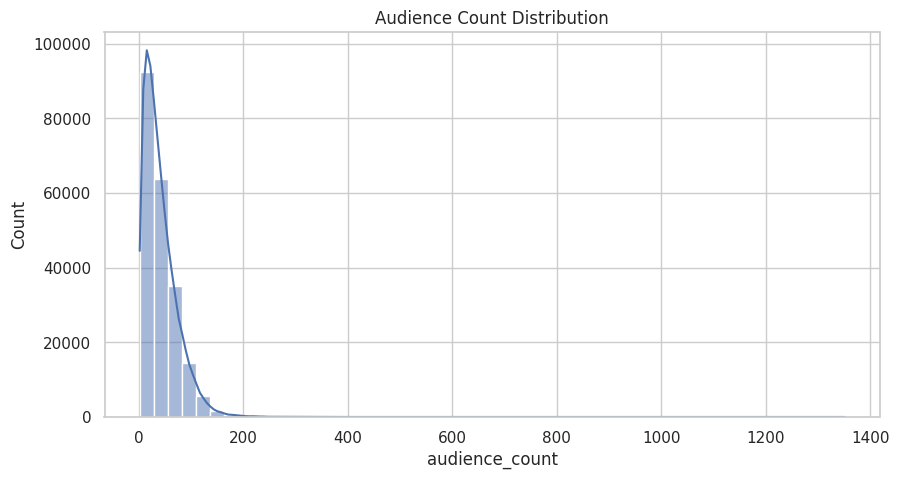

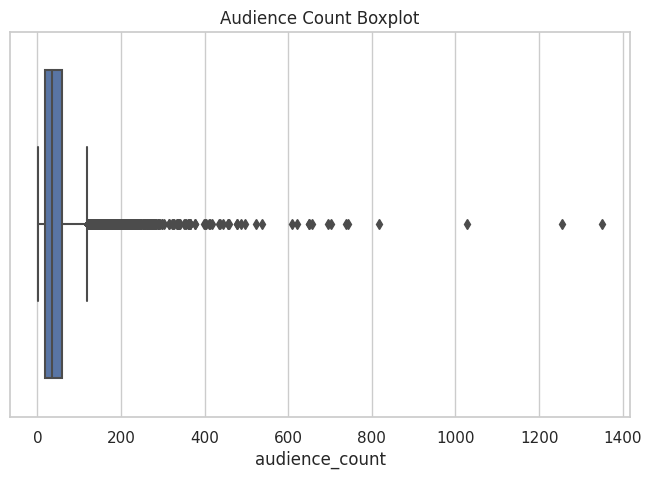

In [25]:
# AUDIENCE DISTRIBUTION
plt.figure(figsize=(10,5))
sns.histplot(data["audience_count"], bins=50, kde=True)
plt.title("Audience Count Distribution")
plt.show()

plt.figure(figsize=(8,5))
sns.boxplot(x=data["audience_count"])
plt.title("Audience Count Boxplot")
plt.show()


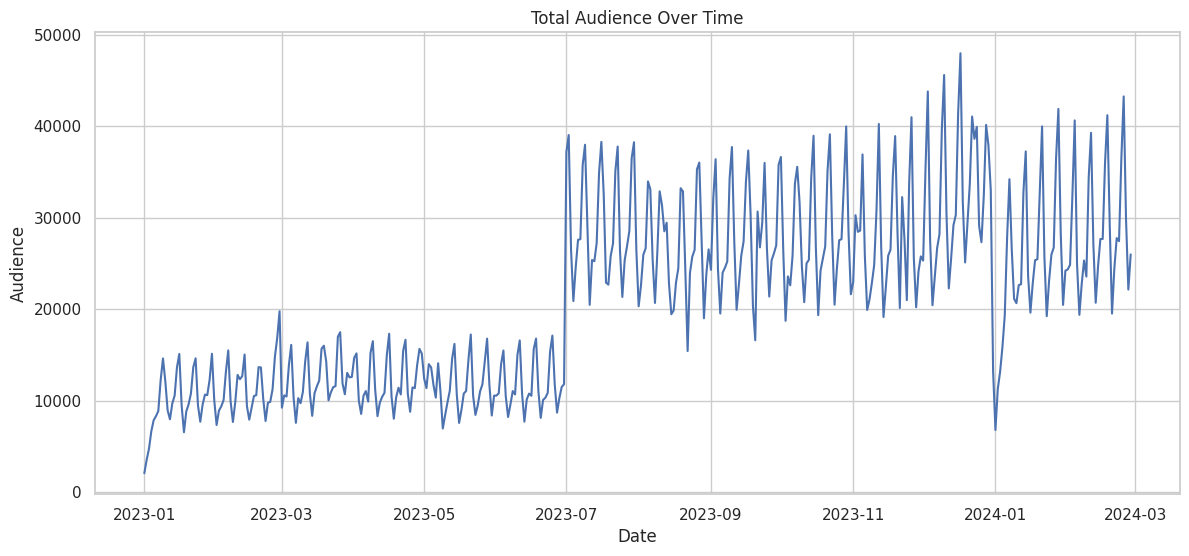

In [26]:
# TIME SERIES ANALYSIS

audience_daily = data.groupby("show_date")["audience_count"].sum().reset_index()

plt.figure(figsize=(14,6))
plt.plot(audience_daily["show_date"], audience_daily["audience_count"])
plt.title("Total Audience Over Time")
plt.xlabel("Date")
plt.ylabel("Audience")
plt.show()

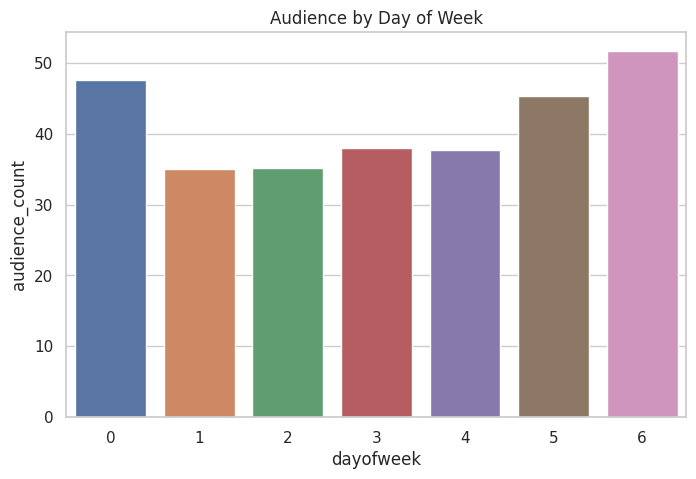

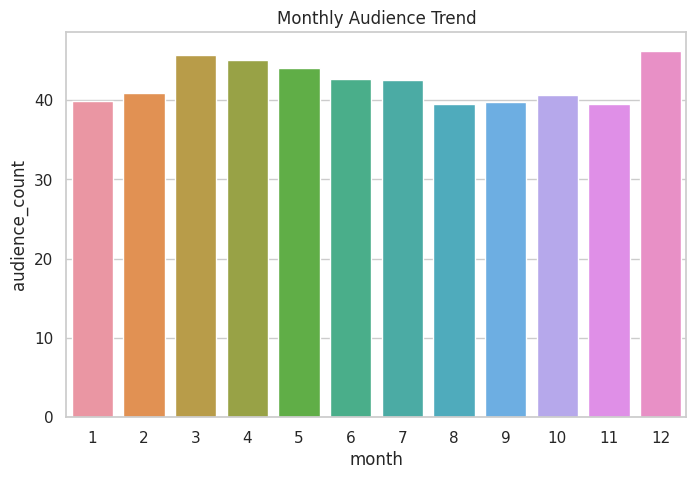

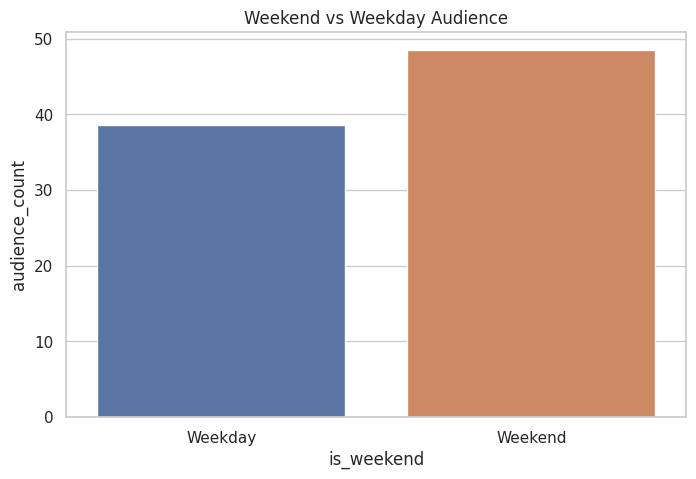

In [27]:
# DAY-OF-WEEK & MONTH PATTERNS

plt.figure(figsize=(8,5))
sns.barplot(data=data, x="dayofweek", y="audience_count", ci=None)
plt.title("Audience by Day of Week")
plt.show()

plt.figure(figsize=(8,5))
sns.barplot(data=data, x="month", y="audience_count", ci=None)
plt.title("Monthly Audience Trend")
plt.show()

plt.figure(figsize=(8,5))
sns.barplot(data=data, x="is_weekend", y="audience_count", ci=None)
plt.title("Weekend vs Weekday Audience")
plt.xticks([0,1], ["Weekday", "Weekend"])
plt.show()


Top 10 theatres by mean audience
    book_theater_id        mean  median        std  min  max
167      book_00169  127.543147   120.0  32.420301   14  218
93       book_00095  127.132743   114.0  82.204830    4  410
150      book_00152  108.880000   130.0  74.464936    4  224
487      book_00490  105.000000   112.0  33.959189    4  170
156      book_00158  101.113772    98.0  62.422812    2  656
585      book_00589   98.449102    88.0  40.816613   34  230
488      book_00491   94.506329    90.0  21.832623   42  144
592      book_00596   93.478261    69.0  86.251760    2  398
290      book_00292   93.465241    98.0  56.153138    4  610
712      book_00716   93.200000    94.0  15.775371   56  136


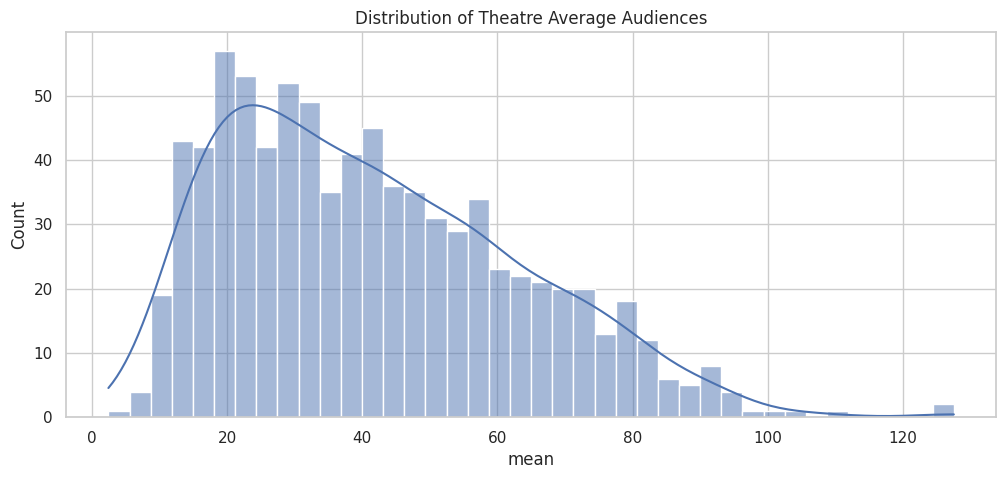

In [28]:
# THEATRE-LEVEL ANALYSIS

theatre_stats = (
    data.groupby("book_theater_id")["audience_count"]
        .agg(["mean", "median", "std", "min", "max"])
        .reset_index()
)

print("\nTop 10 theatres by mean audience")
print(theatre_stats.sort_values("mean", ascending=False).head(10))

plt.figure(figsize=(12,5))
sns.histplot(theatre_stats["mean"], bins=40, kde=True)
plt.title("Distribution of Theatre Average Audiences")
plt.show()


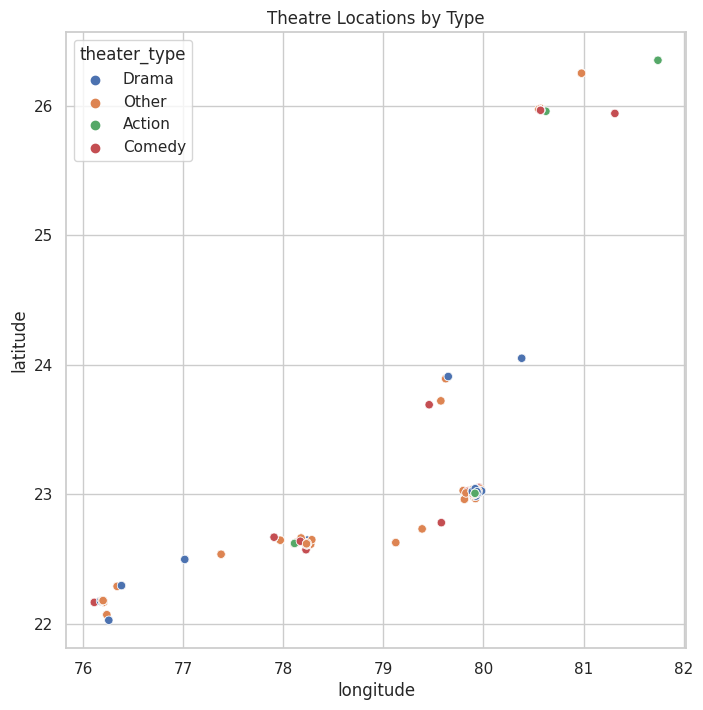

In [29]:
# THEATRE GEOLOCATION (lat/long)

if "latitude" in bnt.columns and "longitude" in bnt.columns:
    plt.figure(figsize=(8,8))
    sns.scatterplot(data=bnt, x="longitude", y="latitude", hue="theater_type")
    plt.title("Theatre Locations by Type")
    plt.show()


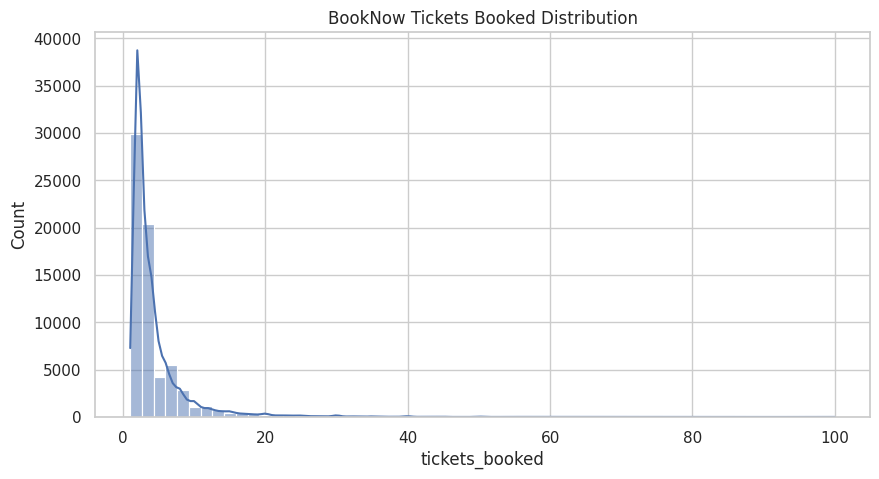

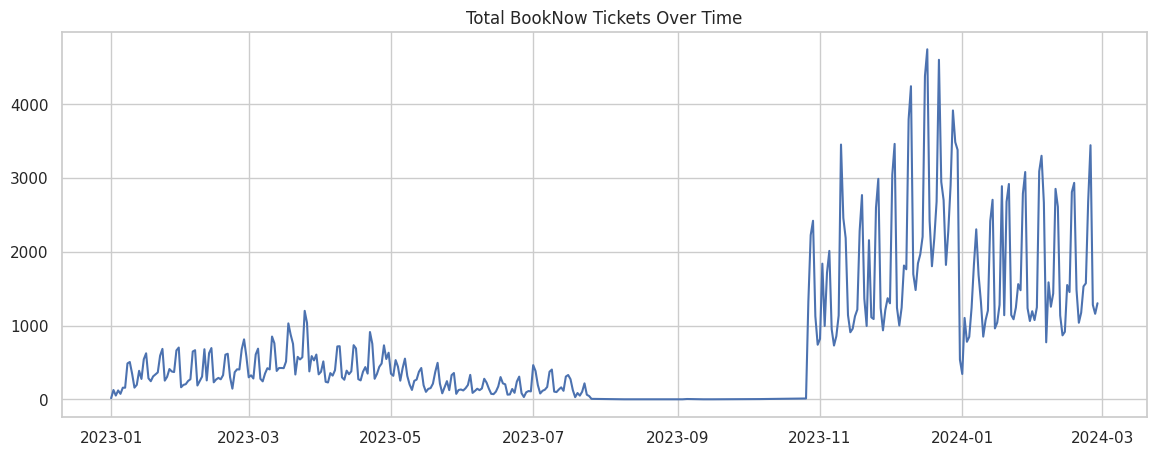

In [30]:
# BOOKNOW BOOKINGS EDA

bnb["show_date"] = bnb["show_datetime"].dt.date

plt.figure(figsize=(10,5))
sns.histplot(bnb["tickets_booked"], bins=60, kde=True)
plt.title("BookNow Tickets Booked Distribution")
plt.show()

bn_daily = bnb.groupby("show_date")["tickets_booked"].sum().reset_index()

plt.figure(figsize=(14,5))
plt.plot(bn_daily["show_date"], bn_daily["tickets_booked"])
plt.title("Total BookNow Tickets Over Time")
plt.show()

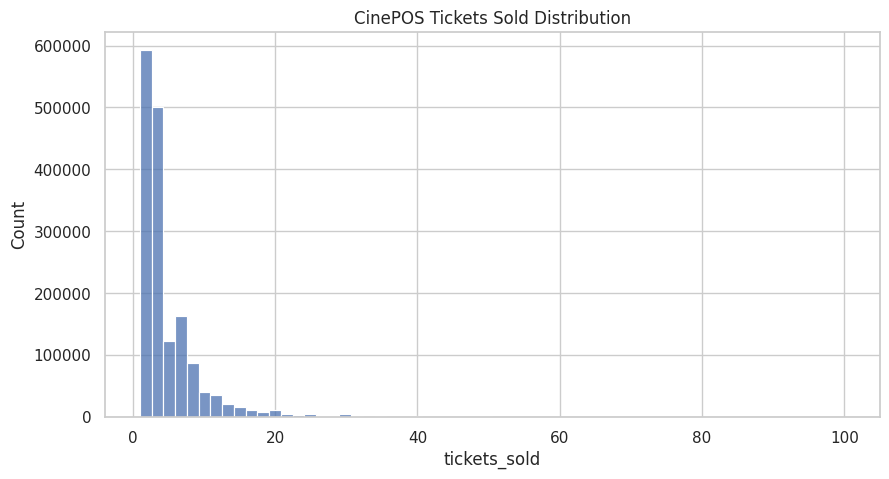

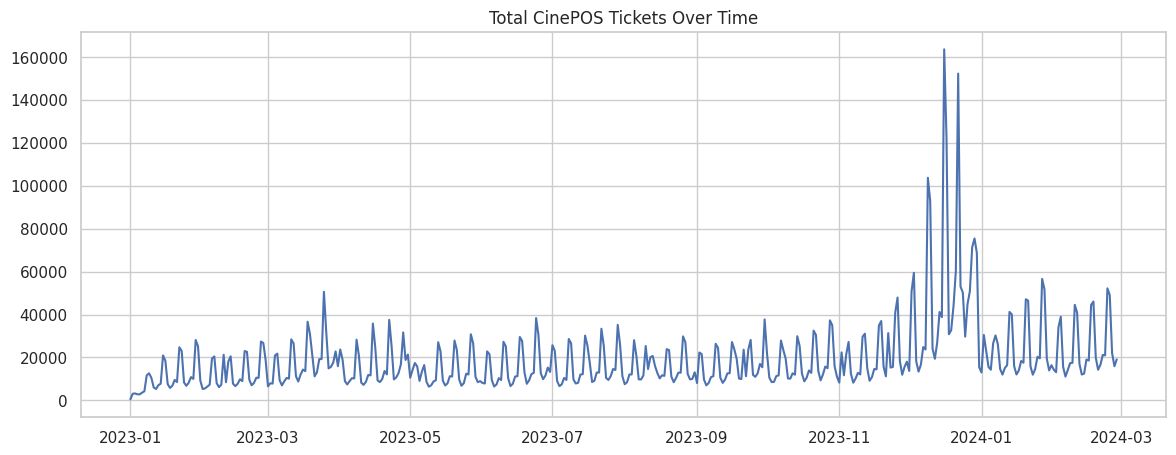

In [31]:
# CINEPOS BOOKINGS EDA

cpb["show_date"] = cpb["show_datetime"].dt.date

plt.figure(figsize=(10,5))
sns.histplot(cpb["tickets_sold"], bins=60)
plt.title("CinePOS Tickets Sold Distribution")
plt.show()

cp_daily = cpb.groupby("show_date")["tickets_sold"].sum().reset_index()

plt.figure(figsize=(14,5))
plt.plot(cp_daily["show_date"], cp_daily["tickets_sold"])
plt.title("Total CinePOS Tickets Over Time")
plt.show()



**2. DATA FEAUTURES**

In [32]:
# 2. Helper: date features
# ============================================================

def add_date_features(df, date_col="show_date"):
    df[date_col] = pd.to_datetime(df[date_col])
    df["year"] = df[date_col].dt.year
    df["month"] = df[date_col].dt.month
    df["day"] = df[date_col].dt.day
    df["dayofweek"] = df[date_col].dt.dayofweek
    df["is_weekend"] = df["dayofweek"].isin([5, 6]).astype(int)
    df["weekofyear"] = df[date_col].dt.isocalendar().week.astype(int)
    df["dayofyear"] = df[date_col].dt.dayofyear
    return df

**3. PRECOMPUTING, CLEANING AND BASIC MERGE**

In [33]:
# 3. Precompute helper tables: bookings, theatre stats, cleaned joins
# ============================================================

# --- 3.1 Clean date_info for merge ---
date_info_clean = date_info.copy()
if "day_of_week" in date_info_clean.columns and "dayofweek_str" not in date_info_clean.columns:
    date_info_clean = date_info_clean.rename(columns={"day_of_week": "dayofweek_str"})

# Dropping any columns that would duplicate with base data except 'show_date'
dup_cols_di = [c for c in date_info_clean.columns if c in data.columns and c != "show_date"]
date_info_clean = date_info_clean.drop(columns=dup_cols_di)

# --- 3.2 Clean bnt (theatre info) for merge ---
bnt_clean = bnt.copy()
dup_cols_bnt = [c for c in bnt_clean.columns if c in data.columns and c != "book_theater_id"]
bnt_clean = bnt_clean.drop(columns=dup_cols_bnt)

# We'll keep latitude and longitude explicitly later; they should be in bnt

# --- 3.3 Aggregate BookNow bookings (bnb) ---
bnb_agg = bnb.copy()
bnb_agg["show_datetime"] = pd.to_datetime(bnb_agg["show_datetime"])
bnb_agg["show_date"] = bnb_agg["show_datetime"].dt.floor("D")

bnb_daily = (
    bnb_agg.groupby(["book_theater_id", "show_date"])
           .agg(
               bn_tickets=("tickets_booked", "sum"),
               bn_num_bookings=("tickets_booked", "count"),
               bn_max_tickets=("tickets_booked", "max")
           )
           .reset_index()
)
bnb_daily["bn_avg_tickets"] = (
    bnb_daily["bn_tickets"] / bnb_daily["bn_num_bookings"]
)

# --- 3.4 Aggregate CinePOS bookings (cpb + rel) ---
cpb_agg = cpb.copy()
cpb_agg["show_datetime"] = pd.to_datetime(cpb_agg["show_datetime"])
cpb_agg["show_date"] = cpb_agg["show_datetime"].dt.floor("D")

cpb_daily = (
    cpb_agg.groupby(["cine_theater_id", "show_date"])
           .agg(
               cp_tickets=("tickets_sold", "sum"),
               cp_num_sales=("tickets_sold", "count"),
               cp_max_tickets=("tickets_sold", "max")
           )
           .reset_index()
)
cpb_daily["cp_avg_tickets"] = (
    cpb_daily["cp_tickets"] / cpb_daily["cp_num_sales"]
)

cpb_daily = cpb_daily.merge(rel, on="cine_theater_id", how="left")
cpb_daily = cpb_daily.dropna(subset=["book_theater_id"])

cpb_daily_reduced = cpb_daily[[
    "book_theater_id", "show_date",
    "cp_tickets", "cp_num_sales", "cp_max_tickets", "cp_avg_tickets"
]]

# --- 3.5 Theatre-level stats from TRAIN ONLY ---
theatre_stats = (
    data.groupby("book_theater_id")["audience_count"]
        .agg(
            th_mean="mean",
            th_median="median",
            th_std="std",
            th_min="min",
            th_max="max"
        )
        .reset_index()
)

**4. FUNCTION BUILDING, FIXING AND MERGES**

In [34]:
# 4.1 Clean date_info and bnt BEFORE build_features
# ============================================================

# Make sure show_date exists and create a string key for joining
date_info["show_date"] = pd.to_datetime(date_info["show_date"], errors="coerce")

date_info_clean = date_info.copy()
if "day_of_week" in date_info_clean.columns and "dayofweek_str" not in date_info_clean.columns:
    date_info_clean = date_info_clean.rename(columns={"day_of_week": "dayofweek_str"})

# Drop duplicate columns except show_date
dup_cols_di = [c for c in date_info_clean.columns if c in data.columns and c != "show_date"]
date_info_clean = date_info_clean.drop(columns=dup_cols_di)

# Create a string key for show_date to avoid dtype issues
date_info_clean["show_date_key"] = date_info_clean["show_date"].dt.strftime("%Y-%m-%d")

# Clean theatre info (bnt)
bnt_clean = bnt.copy()
dup_cols_bnt = [c for c in bnt_clean.columns if c in data.columns and c != "book_theater_id"]
bnt_clean = bnt_clean.drop(columns=dup_cols_bnt)

# ============================================================
# 4.2 Function to build features for any base df
# ============================================================

booking_feature_cols = [
    "bn_tickets", "bn_num_bookings", "bn_max_tickets", "bn_avg_tickets",
    "cp_tickets", "cp_num_sales", "cp_max_tickets", "cp_avg_tickets",
]

def build_features(df_base):
    df = df_base.copy()

    # Ensure show_date is datetime
    df["show_date"] = pd.to_datetime(df["show_date"], errors="coerce")

    # Date features
    df = add_date_features(df, "show_date")

    # Create a matching string key for join
    df["show_date_key"] = df["show_date"].dt.strftime("%Y-%m-%d")

    # Merge calendar info on string key (avoids datetime/object mismatch)
    df = df.merge(
        date_info_clean.drop(columns=["show_date"]),  # keep show_date from df
        on="show_date_key",
        how="left"
    )
    df = df.drop(columns=["show_date_key"])

    # Merge theatre info (includes latitude & longitude & type/area)
    df = df.merge(bnt_clean, on="book_theater_id", how="left")

    # Merge BookNow aggregate bookings
    df = df.merge(
        bnb_daily,
        on=["book_theater_id", "show_date"],
        how="left"
    )

    # Merge CinePOS aggregate bookings
    df = df.merge(
        cpb_daily_reduced,
        on=["book_theater_id", "show_date"],
        how="left"
    )

    # Fill booking-related NaNs with 0
    for col in booking_feature_cols:
        if col in df.columns:
            df[col] = df[col].fillna(0)

    # Merge theatre stats (computed from train data)
    df = df.merge(theatre_stats, on="book_theater_id", how="left")

    return df


**5. BUILDING TRAIN FEATURES**

In [35]:
# 5. Build TRAIN features
# ============================================================

train_base = data[["book_theater_id", "show_date", "audience_count"]].copy()
train_feat = build_features(train_base)

print("train_feat shape:", train_feat.shape)
print(train_feat.head())

train_feat shape: (214046, 28)
  book_theater_id  show_date  audience_count  year  month  day  dayofweek  \
0      book_00001 2023-01-13              50  2023      1   13          4   
1      book_00001 2023-01-14              64  2023      1   14          5   
2      book_00001 2023-01-15              58  2023      1   15          6   
3      book_00001 2023-01-16              44  2023      1   16          0   
4      book_00001 2023-01-18              12  2023      1   18          2   

   is_weekend  weekofyear  dayofyear dayofweek_str theater_type theater_area  \
0           0           2         13        Friday        Drama     Area_002   
1           1           2         14      Saturday        Drama     Area_002   
2           1           2         15        Sunday        Drama     Area_002   
3           0           3         16        Monday        Drama     Area_002   
4           0           3         18     Wednesday        Drama     Area_002   

   latitude  longitude  b

**6. BUILDING TEST FEATURES**

In [36]:
# 6. Build TEST features (from sample_submission)
# ============================================================

test_base = ss.copy()
tmp = test_base["ID"].str.rsplit("_", n=1, expand=True)
test_base["book_theater_id"] = tmp[0]
test_base["show_date"] = pd.to_datetime(tmp[1])

test_feat = build_features(test_base[["book_theater_id", "show_date"]])
print("test_feat shape:", test_feat.shape)
print(test_feat.head())

test_feat shape: (38062, 27)
  book_theater_id  show_date  year  month  day  dayofweek  is_weekend  \
0      book_00001 2024-03-01  2024      3    1          4           0   
1      book_00001 2024-03-02  2024      3    2          5           1   
2      book_00001 2024-03-03  2024      3    3          6           1   
3      book_00001 2024-03-04  2024      3    4          0           0   
4      book_00001 2024-03-06  2024      3    6          2           0   

   weekofyear  dayofyear dayofweek_str theater_type theater_area  latitude  \
0           9         61        Friday        Drama     Area_002  23.00441   
1           9         62      Saturday        Drama     Area_002  23.00441   
2           9         63        Sunday        Drama     Area_002  23.00441   
3          10         64        Monday        Drama     Area_002  23.00441   
4          10         66     Wednesday        Drama     Area_002  23.00441   

   longitude  bn_tickets  bn_num_bookings  bn_max_tickets  bn_a

**7. SMALL FIXES AND FEATURING COLUMNS**

In [37]:
# 7. Define X, y, feature columns
# ============================================================

target_col = "audience_count"

# We'll keep 'book_theater_id' as categorical feature
# We will NOT use raw 'show_date' directly in model.
exclude_cols = ["show_date", target_col, "ID"]

# ensure 'book_theater_id' is string for consistent categorical handling
train_feat["book_theater_id"] = train_feat["book_theater_id"].astype(str)
test_feat["book_theater_id"] = test_feat["book_theater_id"].astype(str)

feature_cols = [c for c in train_feat.columns if c not in exclude_cols]

X = train_feat[feature_cols]
y_raw = train_feat[target_col]          # original target
y = np.log1p(y_raw)                     # log1p transform for modelling
X_test = test_feat[feature_cols]


print("Number of features:", len(feature_cols))

Number of features: 26


**8. SPLITTING DATA - VALIDATION**

In [38]:
# 8. Split for validation (time-based)
# ============================================================

# Use last ~20% of dates as validation to mimic Kaggle test behavior
dates_sorted = np.sort(train_feat["show_date"].unique())
split_idx = int(0.8 * len(dates_sorted))
split_date = dates_sorted[split_idx]
print("Validation split date:", split_date)

train_idx = train_feat["show_date"] < split_date
val_idx   = train_feat["show_date"] >= split_date

X_train = X[train_idx]
y_train_log = y[train_idx]        # log target for training
y_train_raw = y_raw[train_idx]    # original target (for reference if needed)

X_val = X[val_idx]
y_val_log = y[val_idx]            # log target for validation predictions
y_val_raw = y_raw[val_idx]        # original target for RMSE calculation


print("Train shape:", X_train.shape, "Val shape:", X_val.shape)

Validation split date: 2023-12-06T00:00:00.000000000
Train shape: (156529, 26) Val shape: (57517, 26)


**9. PREPROCESING AND COLUMN TRANSFORMERS**

In [39]:
# 9. Preprocessing with ColumnTransformer
# ============================================================

# Identify numeric & categorical columns automatically
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(include=["object", "category"]).columns.tolist()

print("Numeric features:", len(numeric_features))
print("Categorical features:", categorical_features)

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

Numeric features: 22
Categorical features: ['book_theater_id', 'dayofweek_str', 'theater_type', 'theater_area']


**10. TUNING & PIPELINES BUILDING (Linear, XGB, LGBM)**

In [40]:
# 10. Hyperparameter tuning + training + submission (log target) + Pipelines Build
# ============================================================

from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from scipy.stats import randint, uniform

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# ---- 10.1 Prepare log-transformed targets ----
# y currently = audience_count from your previous code
y_raw = y.copy()

# Use the same time-based split masks you already created
y_train_raw = y_raw[train_idx]
y_val_raw   = y_raw[val_idx]

y_train_log = np.log1p(y_train_raw)
y_val_log   = np.log1p(y_val_raw)

lin_pipe = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", LinearRegression())
])

xgb_pipe = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", XGBRegressor(
        objective="reg:squarederror",
        tree_method="hist",
        random_state=RANDOM_STATE
    ))
])

lgb_pipe = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", LGBMRegressor(
        random_state=RANDOM_STATE
    ))
])

# TimeSeries CV for tuning
tscv = TimeSeriesSplit(n_splits=3)

**11. RandomizedSearchCV for XGBoost & LightGBM**

In [41]:
xgb_param_dist = {
    "regressor__n_estimators": randint(400, 1400),
    "regressor__max_depth": randint(4, 12),
    "regressor__learning_rate": uniform(0.01, 0.08),   # 0.01–0.09
    "regressor__subsample": uniform(0.7, 0.3),         # 0.7–1.0
    "regressor__colsample_bytree": uniform(0.6, 0.4),  # 0.6–1.0
    "regressor__min_child_weight": randint(1, 10),
    "regressor__gamma": uniform(0.0, 0.3),
}

print("\n=== RandomizedSearchCV for XGBoost ===")
xgb_search = RandomizedSearchCV(
    estimator=xgb_pipe,
    param_distributions=xgb_param_dist,
    n_iter=20,
    scoring="neg_root_mean_squared_error",  # on log target
    cv=tscv,
    verbose=1,
    random_state=RANDOM_STATE,
    n_jobs=-1,
)

xgb_search.fit(X_train, y_train_log)
print("Best XGB params:", xgb_search.best_params_)
print("Best XGB CV RMSE (log space):", -xgb_search.best_score_)
best_xgb = xgb_search.best_estimator_

lgb_param_dist = {
    "regressor__n_estimators": randint(400, 1400),
    "regressor__learning_rate": uniform(0.01, 0.08),
    "regressor__num_leaves": randint(31, 255),
    "regressor__max_depth": randint(4, 16),
    "regressor__subsample": uniform(0.7, 0.3),
    "regressor__colsample_bytree": uniform(0.6, 0.4),
    "regressor__reg_alpha": uniform(0.0, 0.5),
    "regressor__reg_lambda": uniform(0.0, 0.5),
}

print("\n=== RandomizedSearchCV for LightGBM ===")
lgb_search = RandomizedSearchCV(
    estimator=lgb_pipe,
    param_distributions=lgb_param_dist,
    n_iter=20,
    scoring="neg_root_mean_squared_error",  # on log target
    cv=tscv,
    verbose=1,
    random_state=RANDOM_STATE,
    n_jobs=-1,
)

lgb_search.fit(X_train, y_train_log)
print("Best LGBM params:", lgb_search.best_params_)
print("Best LGBM CV RMSE (log space):", -lgb_search.best_score_)
best_lgb = lgb_search.best_estimator_


=== RandomizedSearchCV for XGBoost ===
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best XGB params: {'regressor__colsample_bytree': 0.6180909155642152, 'regressor__gamma': 0.0975990992289793, 'regressor__learning_rate': 0.04109418317515856, 'regressor__max_depth': 5, 'regressor__min_child_weight': 5, 'regressor__n_estimators': 1191, 'regressor__subsample': 0.8070259980080767}
Best XGB CV RMSE (log space): 0.1585413151761134

=== RandomizedSearchCV for LightGBM ===
Fitting 3 folds for each of 20 candidates, totalling 60 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.028400 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2071
[LightGBM] [Info] Number of data points in the train set: 39133, number of used features: 290
[LightGBM] [Info] Start training from score 1.492607
[LightGBM] [Warning] No further splits with p

**12. Evaluate tuned models + Linear Regression on validation (RMSE on ORIGINAL audience scale)N**

In [42]:
val_scores = {}

# ---- Linear Regression baseline (also on log target) ----
print("\n=== Evaluating Linear Regression on validation set ===")
lin_pipe.fit(X_train, y_train_log)
lin_val_log = lin_pipe.predict(X_val)
lin_val_pred = np.expm1(lin_val_log)             # back to audience scale
val_scores["LinearRegression"] = rmse(y_val_raw, lin_val_pred)
print("LinearRegression Val RMSE:", val_scores["LinearRegression"])

# ---- Tuned XGBoost ----
print("\n=== Evaluating tuned XGBoost on validation set ===")
xgb_val_log = best_xgb.predict(X_val)
xgb_val_pred = np.expm1(xgb_val_log)
val_scores["XGBoost_tuned"] = rmse(y_val_raw, xgb_val_pred)
print("XGBoost_tuned Val RMSE:", val_scores["XGBoost_tuned"])

# ---- Tuned LightGBM ----
print("\n=== Evaluating tuned LightGBM on validation set ===")
lgb_val_log = best_lgb.predict(X_val)
lgb_val_pred = np.expm1(lgb_val_log)
val_scores["LightGBM_tuned"] = rmse(y_val_raw, lgb_val_pred)
print("LightGBM_tuned Val RMSE:", val_scores["LightGBM_tuned"])

# ---- Simple ensemble of tuned XGB + LGBM ----
ensemble_val_pred = 0.5 * xgb_val_pred + 0.5 * lgb_val_pred
val_scores["XGB+LGBM_ensemble"] = rmse(y_val_raw, ensemble_val_pred)
print("XGB+LGBM_ensemble Val RMSE:", val_scores["XGB+LGBM_ensemble"])

print("\nValidation RMSE scores:", val_scores)

best_model_name = min(val_scores, key=val_scores.get)
print(f"\nBest model based on validation RMSE: {best_model_name}")



=== Evaluating Linear Regression on validation set ===
LinearRegression Val RMSE: 5.4070972486175215

=== Evaluating tuned XGBoost on validation set ===
XGBoost_tuned Val RMSE: 0.6200261920934463

=== Evaluating tuned LightGBM on validation set ===
LightGBM_tuned Val RMSE: 0.6154922304661252
XGB+LGBM_ensemble Val RMSE: 0.6155067241215871

Validation RMSE scores: {'LinearRegression': 5.4070972486175215, 'XGBoost_tuned': 0.6200261920934463, 'LightGBM_tuned': 0.6154922304661252, 'XGB+LGBM_ensemble': 0.6155067241215871}

Best model based on validation RMSE: LightGBM_tuned


**13. Train final models on FULL training data (log target)**

In [43]:
print("\nTraining final model(s) on FULL training data (log target)...")
y_full_log = np.log1p(y_raw)

# Refit tuned models & linear on all data
best_xgb_full = xgb_search.best_estimator_
best_lgb_full = lgb_search.best_estimator_
lin_full      = lin_pipe

best_xgb_full.fit(X, y_full_log)
best_lgb_full.fit(X, y_full_log)
lin_full.fit(X, y_full_log)

# Test predictions for each model
xgb_test_log = best_xgb_full.predict(X_test)
lgb_test_log = best_lgb_full.predict(X_test)
lin_test_log = lin_full.predict(X_test)

xgb_test_pred = np.expm1(xgb_test_log)
lgb_test_pred = np.expm1(lgb_test_log)
lin_test_pred = np.expm1(lin_test_log)

# Choose final predictions based on best_model_name
if best_model_name == "XGB+LGBM_ensemble":
    test_preds = 0.5 * xgb_test_pred + 0.5 * lgb_test_pred
elif best_model_name == "XGBoost_tuned":
    test_preds = xgb_test_pred
elif best_model_name == "LightGBM_tuned":
    test_preds = lgb_test_pred
else:
    test_preds = lin_test_pred

test_preds = np.clip(test_preds, 0, None)


Training final model(s) on FULL training data (log target)...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.155479 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3714
[LightGBM] [Info] Number of data points in the train set: 214046, number of used features: 926
[LightGBM] [Info] Start training from score 1.471037
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Lig

**14. CREATING FINAL SUBMISSION**

In [44]:
submission = ss.copy()
submission["audience_count"] = test_preds

submission.to_csv("submission.csv", index=False)
print("\nSaved submission.csv")
print(submission.head())
print("Submission shape:", submission.shape)


Saved submission.csv
                      ID  audience_count
0  book_00001_2024-03-01        3.604195
1  book_00001_2024-03-02        3.842490
2  book_00001_2024-03-03        3.963895
3  book_00001_2024-03-04        3.689693
4  book_00001_2024-03-06        3.478186
Submission shape: (38062, 2)
